In [1]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152xs
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # -1  to USE CPU
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

get_ipython().magic(u'matplotlib inline')

/var/folders/90/q467pqns6cxc4dmbvlrlxbqm0000gn/T/ipykernel_9823/2964376139.py:18: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')


In [2]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    return new_image

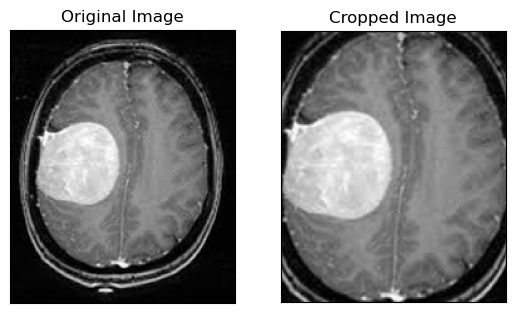

In [3]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            print(filename)
            print(directory)
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # print(image)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    # Shuffle the data
    X, y = shuffle(X, y)
    print('Number of examples is:{}'.format(len(X)))
    return X,y

In [5]:
augmented_path = 'augmented_data/'
# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

aug_Y100_0_4855.jpg
augmented_data/yes
aug_Y254_0_4212.jpg
augmented_data/yes
aug_Y37_0_9694.jpg
augmented_data/yes
aug_Y243_0_9105.jpg
augmented_data/yes
aug_Y106_0_2432.jpg
augmented_data/yes
aug_Y154_0_1160.jpg
augmented_data/yes
aug_Y82_0_3407.jpg
augmented_data/yes
aug_Y117_0_9217.jpg
augmented_data/yes
aug_Y159_0_2278.jpg
augmented_data/yes
aug_Y256_0_9393.jpg
augmented_data/yes
aug_Y35_0_5351.jpg
augmented_data/yes
aug_Y24_0_7550.jpg
augmented_data/yes
aug_Y62_0_7861.jpg
augmented_data/yes
aug_Y36_0_3276.jpg
augmented_data/yes
aug_Y2_0_9038.jpg
augmented_data/yes
aug_Y15_0_537.jpg
augmented_data/yes
aug_Y161_0_4244.jpg
augmented_data/yes
aug_Y105_0_1041.jpg
augmented_data/yes
aug_Y7_0_1893.jpg
augmented_data/yes
aug_Y31_0_2292.jpg
augmented_data/yes
aug_Y55_0_3597.jpg
augmented_data/yes
aug_Y42_0_5931.jpg
augmented_data/yes
aug_Y1_0_5234.jpg
augmented_data/yes
aug_Y113_0_9120.jpg
augmented_data/yes
aug_Y70_0_5465.jpg
augmented_data/yes
aug_Y10_0_5995.jpg
augmented_data/yes
aug_Y

aug_Y42_0_7189.jpg
augmented_data/yes
aug_Y29_0_7524.jpg
augmented_data/yes
aug_Y115_0_6496.jpg
augmented_data/yes
aug_Y11_0_4064.jpg
augmented_data/yes
aug_Y157_0_6500.jpg
augmented_data/yes
aug_Y50_0_9143.jpg
augmented_data/yes
aug_Y16_0_3750.jpg
augmented_data/yes
aug_Y111_0_5337.jpg
augmented_data/yes
aug_Y46_0_9481.jpg
augmented_data/yes
aug_Y99_0_6022.jpg
augmented_data/yes
aug_Y165_0_8887.jpg
augmented_data/yes
aug_Y41_0_9801.jpg
augmented_data/yes
aug_Y30_0_1144.jpg
augmented_data/yes
aug_Y255_0_6184.jpg
augmented_data/yes
aug_Y116_0_9027.jpg
augmented_data/yes
aug_Y40_0_8839.jpg
augmented_data/yes
aug_Y49_0_1095.jpg
augmented_data/yes
aug_Y81_0_427.jpg
augmented_data/yes
aug_Y195_0_1949.jpg
augmented_data/yes
aug_Y89_0_5829.jpg
augmented_data/yes
aug_Y106_0_8790.jpg
augmented_data/yes
aug_Y19_0_7230.jpg
augmented_data/yes
aug_Y45_0_2256.jpg
augmented_data/yes
aug_Y85_0_3562.jpg
augmented_data/yes
aug_Y170_0_1360.jpg
augmented_data/yes
aug_Y35_0_6982.jpg
augmented_data/yes
aug_

aug_Y162_0_4007.jpg
augmented_data/yes
aug_Y183_0_3643.jpg
augmented_data/yes
aug_Y120_0_6235.jpg
augmented_data/yes
aug_Y31_0_833.jpg
augmented_data/yes
aug_Y91_0_8970.jpg
augmented_data/yes
aug_Y27_0_7129.jpg
augmented_data/yes
aug_Y73_0_4289.jpg
augmented_data/yes
aug_Y102_0_8273.jpg
augmented_data/yes
aug_Y162_0_654.jpg
augmented_data/yes
aug_Y253_0_7900.jpg
augmented_data/yes
aug_Y257_0_9993.jpg
augmented_data/yes
aug_Y62_0_5744.jpg
augmented_data/yes
aug_Y156_0_2097.jpg
augmented_data/yes
aug_Y51_0_1588.jpg
augmented_data/yes
aug_Y146_0_3091.jpg
augmented_data/yes
aug_Y32_0_556.jpg
augmented_data/yes
aug_Y12_0_9172.jpg
augmented_data/yes
aug_Y104_0_8522.jpg
augmented_data/yes
aug_Y12_0_4318.jpg
augmented_data/yes
aug_Y112_0_8989.jpg
augmented_data/yes
aug_Y18_0_5314.jpg
augmented_data/yes
aug_Y116_0_1244.jpg
augmented_data/yes
aug_Y155_0_4403.jpg
augmented_data/yes
aug_Y116_0_3321.jpg
augmented_data/yes
aug_Y154_0_1649.jpg
augmented_data/yes
aug_Y92_0_7244.jpg
augmented_data/yes


aug_Y181_0_9847.jpg
augmented_data/yes
aug_Y257_0_8677.jpg
augmented_data/yes
aug_Y79_0_1376.jpg
augmented_data/yes
aug_Y2_0_3036.jpg
augmented_data/yes
aug_Y6_0_3275.jpg
augmented_data/yes
aug_Y26_0_3840.jpg
augmented_data/yes
aug_Y30_0_3399.jpg
augmented_data/yes
aug_Y183_0_7571.jpg
augmented_data/yes
aug_Y100_0_2052.jpg
augmented_data/yes
aug_Y81_0_614.jpg
augmented_data/yes
aug_Y33_0_2314.jpg
augmented_data/yes
aug_Y109_0_3468.jpg
augmented_data/yes
aug_Y29_0_1824.jpg
augmented_data/yes
aug_Y154_0_5037.jpg
augmented_data/yes
aug_Y98_0_2422.jpg
augmented_data/yes
aug_Y16_0_1407.jpg
augmented_data/yes
aug_Y79_0_3171.jpg
augmented_data/yes
aug_Y79_0_7317.jpg
augmented_data/yes
aug_Y161_0_4997.jpg
augmented_data/yes
aug_Y22_0_526.jpg
augmented_data/yes
aug_Y65_0_7935.jpg
augmented_data/yes
aug_Y259_0_3277.jpg
augmented_data/yes
aug_Y25_0_6659.jpg
augmented_data/yes
aug_Y242_0_9310.jpg
augmented_data/yes
aug_Y245_0_9161.jpg
augmented_data/yes
aug_Y104_0_4099.jpg
augmented_data/yes
aug_Y

aug_Y38_0_3934.jpg
augmented_data/yes
aug_Y46_0_3666.jpg
augmented_data/yes
aug_Y75_0_3182.jpg
augmented_data/yes
aug_Y167_0_5565.jpg
augmented_data/yes
aug_Y46_0_9405.jpg
augmented_data/yes
aug_Y67_0_319.jpg
augmented_data/yes
aug_Y16_0_2353.jpg
augmented_data/yes
aug_Y249_0_6934.jpg
augmented_data/yes
aug_Y251_0_3763.jpg
augmented_data/yes
aug_Y257_0_6957.jpg
augmented_data/yes
aug_Y75_0_6979.jpg
augmented_data/yes
aug_Y181_0_6445.jpg
augmented_data/yes
aug_Y253_0_3113.jpg
augmented_data/yes
aug_Y162_0_7799.jpg
augmented_data/yes
aug_Y99_0_8511.jpg
augmented_data/yes
aug_Y182_0_5624.jpg
augmented_data/yes
aug_Y45_0_891.jpg
augmented_data/yes
aug_Y53_0_6204.jpg
augmented_data/yes
aug_Y69_0_8362.jpg
augmented_data/yes
aug_Y61_0_6822.jpg
augmented_data/yes
aug_Y53_0_2923.jpg
augmented_data/yes
aug_Y40_0_6304.jpg
augmented_data/yes
aug_Y107_0_5499.jpg
augmented_data/yes
aug_Y23_0_296.jpg
augmented_data/yes
aug_Y45_0_2365.jpg
augmented_data/yes
aug_Y22_0_197.jpg
augmented_data/yes
aug_Y25

aug_10 no_0_673.jpg
augmented_data/no
aug_2 no._0_1186.jpg
augmented_data/no
aug_11 no_0_1187.jpg
augmented_data/no
aug_No14_0_5497.jpg
augmented_data/no
aug_31 no_0_2563.jpg
augmented_data/no
aug_No12_0_1956.jpg
augmented_data/no
aug_46 no_0_337.jpg
augmented_data/no
aug_44no_0_285.jpg
augmented_data/no
aug_no 10_0_3973.jpg
augmented_data/no
aug_N17_0_5694.jpg
augmented_data/no
aug_19 no_0_5986.jpg
augmented_data/no
aug_32 no_0_1053.jpg
augmented_data/no
aug_no 6_0_222.jpg
augmented_data/no
aug_27 no_0_1689.jpg
augmented_data/no
aug_44no_0_3962.jpg
augmented_data/no
aug_No12_0_8379.jpg
augmented_data/no
aug_N16_0_647.jpg
augmented_data/no
aug_11 no_0_6207.jpg
augmented_data/no
aug_no 9_0_8035.jpg
augmented_data/no
aug_31 no_0_9740.jpg
augmented_data/no
aug_28 no_0_5487.jpg
augmented_data/no
aug_N20_0_7108.jpg
augmented_data/no
aug_44no_0_859.jpg
augmented_data/no
aug_no 94_0_7907.jpg
augmented_data/no
aug_33 no_0_2144.jpg
augmented_data/no
aug_N11_0_4754.jpg
augmented_data/no
aug_no 9

aug_30 no_0_1911.jpg
augmented_data/no
aug_no 7._0_6519.jpg
augmented_data/no
aug_No18_0_916.jpg
augmented_data/no
aug_no 97_0_6955.jpg
augmented_data/no
aug_no 10_0_6368.jpg
augmented_data/no
aug_7 no_0_3071.jpg
augmented_data/no
aug_15 no_0_2726.jpg
augmented_data/no
aug_49 no_0_357.jpg
augmented_data/no
aug_36 no_0_6669.jpg
augmented_data/no
aug_no 5._0_5804.jpg
augmented_data/no
aug_10 no_0_8827.jpg
augmented_data/no
aug_No11_0_3388.jpg
augmented_data/no
aug_43 no_0_9379.jpg
augmented_data/no
aug_No16_0_3674.jpg
augmented_data/no
aug_no 1_0_4012.jpg
augmented_data/no
aug_31 no_0_4899.jpg
augmented_data/no
aug_N26_0_6770.jpg
augmented_data/no
aug_27 no_0_1521.jpg
augmented_data/no
aug_no 3_0_1097.jpg
augmented_data/no
aug_8 no_0_7915.jpg
augmented_data/no
aug_3 no_0_2227.jpg
augmented_data/no
aug_No22_0_5223.jpg
augmented_data/no
aug_N3_0_5494.jpg
augmented_data/no
aug_N22_0_7639.jpg
augmented_data/no
aug_20 no_0_657.jpg
augmented_data/no
aug_N5_0_956.jpg
augmented_data/no
aug_no 6_

aug_no 100_0_6285.jpg
augmented_data/no
aug_41 no_0_3577.jpg
augmented_data/no
aug_no 2_0_7601.jpg
augmented_data/no
aug_15 no_0_5610.jpg
augmented_data/no
aug_No20_0_1723.jpg
augmented_data/no
aug_no 92_0_1053.jpg
augmented_data/no
aug_No18_0_1018.jpg
augmented_data/no
aug_10 no_0_383.jpg
augmented_data/no
aug_41 no_0_4813.jpg
augmented_data/no
aug_23 no_0_7084.jpg
augmented_data/no
aug_no 10_0_714.jpg
augmented_data/no
aug_31 no_0_9850.jpg
augmented_data/no
aug_1 no._0_3940.jpg
augmented_data/no
aug_3 no_0_1002.jpg
augmented_data/no
aug_no 97_0_9152.jpg
augmented_data/no
aug_No17_0_1864.jpg
augmented_data/no
aug_no 89_0_5938.jpg
augmented_data/no
aug_no 3_0_865.jpg
augmented_data/no
aug_25 no_0_2280.jpg
augmented_data/no
aug_N2_0_6795.jpg
augmented_data/no
aug_26 no_0_3428.jpg
augmented_data/no
aug_22 no_0_3777.jpg
augmented_data/no
aug_30 no_0_4604.jpg
augmented_data/no
aug_14 no_0_5794.jpg
augmented_data/no
aug_no 97_0_3683.jpg
augmented_data/no
aug_29 no_0_4448.jpg
augmented_data/

Number of examples is:2065


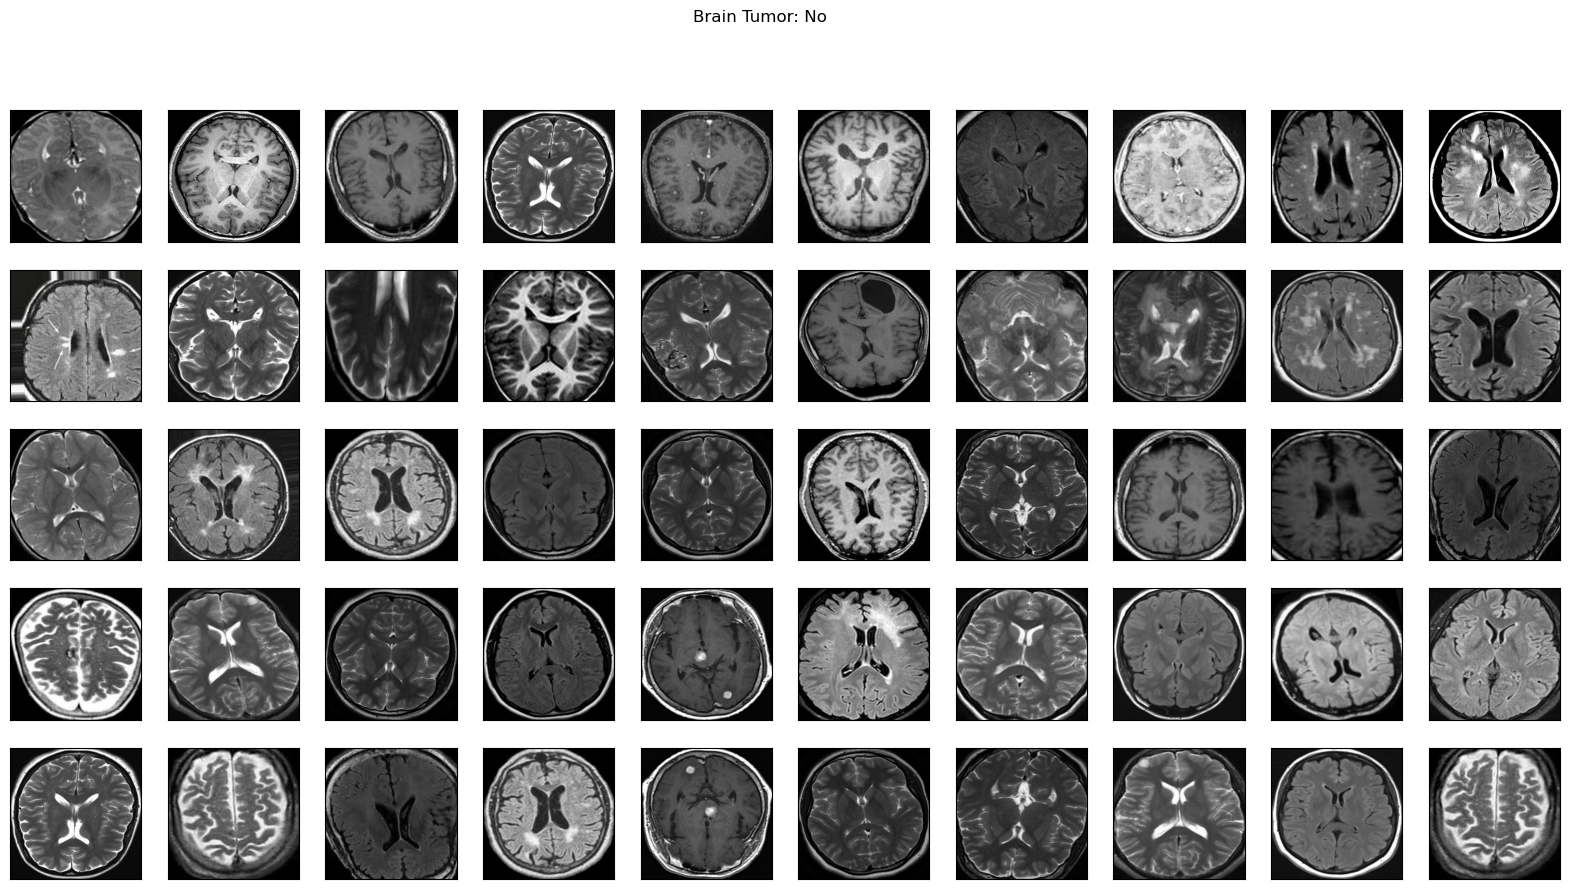

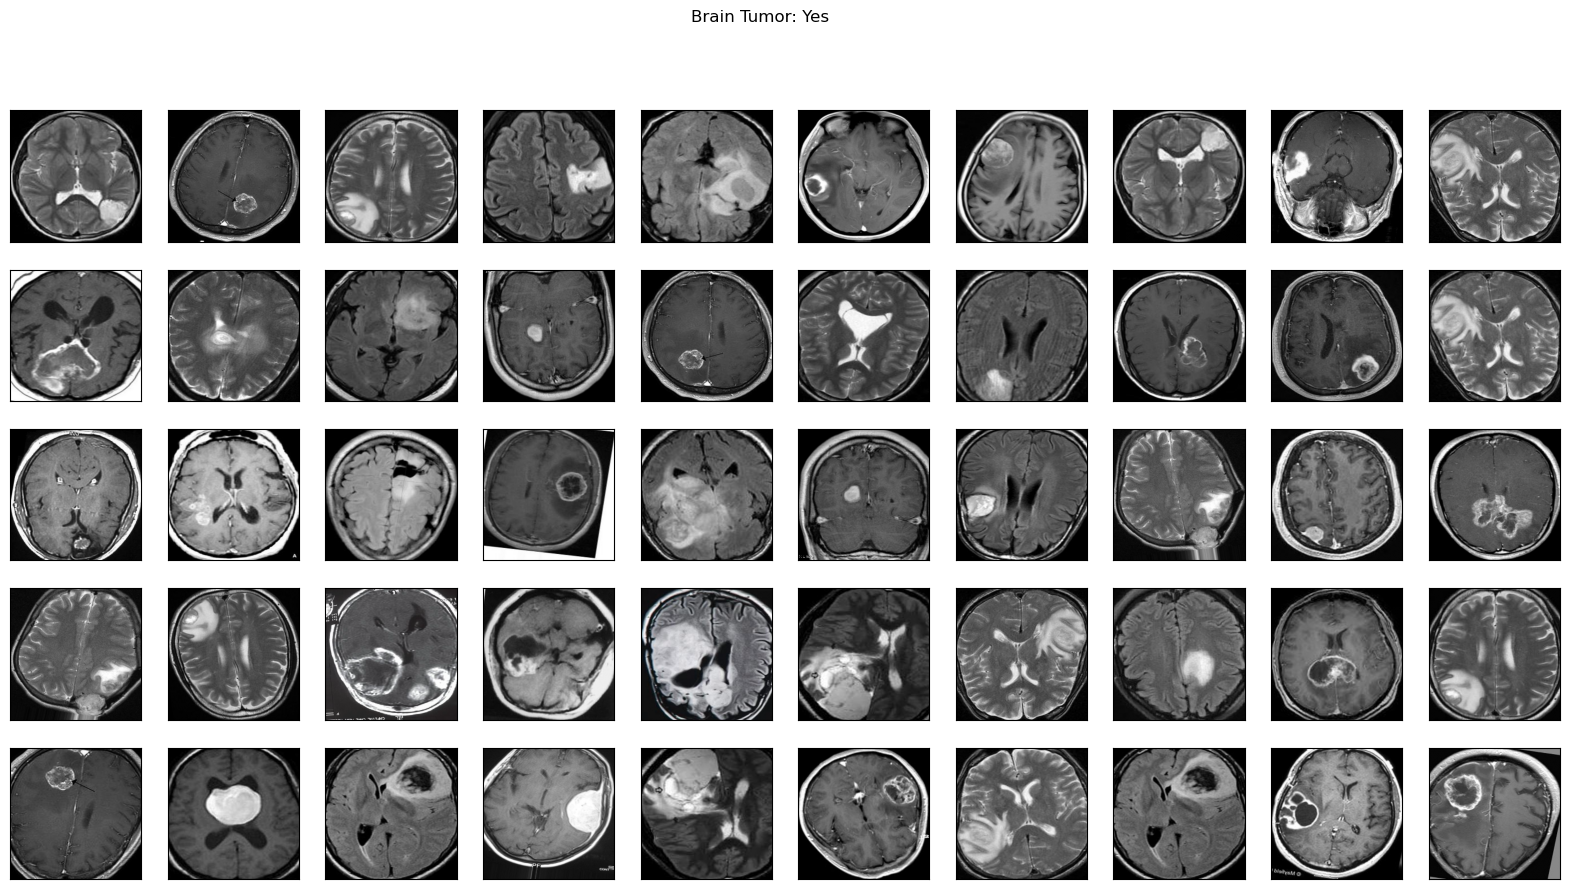

In [6]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle("Brain Tumor: {}".format(label_to_str(label)))
        plt.show()

plot_sample_images(X, y)

In [7]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [9]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [10]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{}:{}".format(h,m,round(s,1))

In [11]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)

    return score

In [12]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # 

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X) # 
    # X=Dropout(0.50)(X)


    X = Conv2D(128, (5, 5), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)  # shape=(?, 238, 238, 32)
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    X=Dropout(0.50)(X)

    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)


    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [13]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 64)      1792      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 64)      256       
                                                                 
 activation (Activation)     (None, 238, 238, 64)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 119, 119, 64)      0         
                                                                 
 conv1 (Conv2D)              (None, 58, 58, 128)       204928    
                                                                 
 bn1 (BatchNormalization)    (None, 58, 58, 128

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


import time

# tensorboard
log_file_name = 'brain_tumor_detection_cnn_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(log_file_name))




# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.keras".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

#checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
checkpoint = ModelCheckpoint('model_checkpoint.keras', monitor='val_loss', save_best_only=True)


# Start the timer
start_time = time.time()

# Train the model
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, 
                    validation_data=(X_val, y_val), 
                    callbacks=[reduce_lr, tensorboard, checkpoint])

# End the timer
end_time = time.time()
execution_time = end_time - start_time

# Print elapsed time
print("Elapsed time: {}".format(hms_string(execution_time)))

Epoch 1/10
46/46 [==============================] - 56s 1s/step - loss: 1.8194 - accuracy: 0.5792 - val_loss: 1.1138 - val_accuracy: 0.5323 - lr: 0.0010
Epoch 2/10
46/46 [==============================] - 57s 1s/step - loss: 0.6647 - accuracy: 0.7197 - val_loss: 1.1372 - val_accuracy: 0.5323 - lr: 0.0010
Epoch 3/10
46/46 [==============================] - 58s 1s/step - loss: 0.5698 - accuracy: 0.7557 - val_loss: 0.9564 - val_accuracy: 0.5419 - lr: 0.0010
Epoch 4/10
46/46 [==============================] - 57s 1s/step - loss: 0.5246 - accuracy: 0.7945 - val_loss: 0.8046 - val_accuracy: 0.5419 - lr: 0.0010
Epoch 5/10
46/46 [==============================] - 57s 1s/step - loss: 0.4816 - accuracy: 0.7958 - val_loss: 0.8421 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 6/10
46/46 [==============================] - 53s 1s/step - loss: 0.4007 - accuracy: 0.8374 - val_loss: 1.2666 - val_accuracy: 0.5452 - lr: 0.0010
Epoch 7/10
46/46 [==============================] - 59s 1s/step - loss: 0.3580 - a

In [17]:
history = model.history.history

for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy
lr


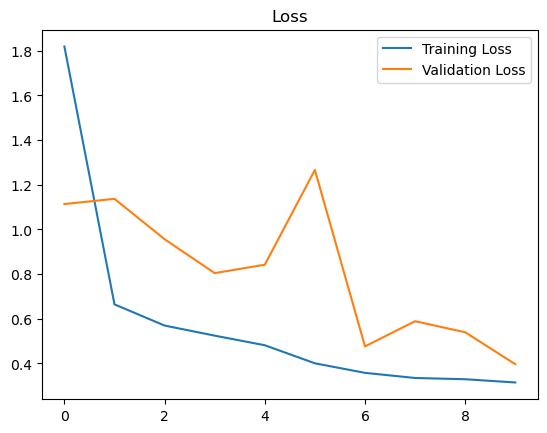

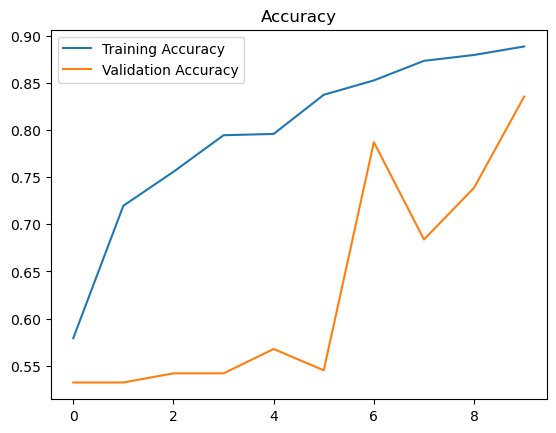

In [18]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()




plot_metrics(history)


In [19]:
model.metrics_names

['loss', 'accuracy']

In [20]:
loss, acc =model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 3s 306ms/step - loss: 0.4125 - accuracy: 0.8129


In [21]:
print ("Test Loss = {}".format(loss))
print ("Test Accuracy = {}".format(acc))

Test Loss = 0.41250133514404297
Test Accuracy = 0.8129032254219055


In [22]:
y_test_prob = model.predict(X_test)

10/10 [==============================] - 3s 295ms/step


In [23]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")


F1 score: 0.8284023668639052


In [24]:
y_val_prob = model.predict(X_val)

10/10 [==============================] - 3s 310ms/step


In [25]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8477611940298508


In [26]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print("Number of examples:{}".format(m))
    print("Percentage of positive examples: {}%, number of pos examples: {}".format(pos_prec,n_positive))
    print("Percentage of negative examples: {}%, number of neg examples: {}".format(neg_prec,n_negative))

In [27]:
data_percentage(y)

Number of examples:2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [28]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples:1445
Percentage of positive examples: 52.38754325259516%, number of pos examples: 757
Percentage of negative examples: 47.61245674740484%, number of neg examples: 688
Validation Data:
Number of examples:310
Percentage of positive examples: 53.225806451612904%, number of pos examples: 165
Percentage of negative examples: 46.774193548387096%, number of neg examples: 145
Testing Data:
Number of examples:310
Percentage of positive examples: 52.58064516129032%, number of pos examples: 163
Percentage of negative examples: 47.41935483870968%, number of neg examples: 147


In [29]:
#print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")
print(f"F1 score: {f1score_val}")

Test Accuracy = 0.8129032254219055
F1 score: 0.8477611940298508
